In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%config InlineBackend.figure_formats = {'png', 'retina'}
import os, zipfile, io, re
from PIL import Image
from sklearn.model_selection import train_test_split
from keras.applications.xception import Xception
from keras.models import Model, load_model
from keras.layers.core import Dense
from keras.layers.pooling import GlobalAveragePooling2D
from keras.optimizers import Adam, RMSprop, SGD
from keras.utils.np_utils import to_categorical
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [2]:
image_size = 200

In [68]:
%%time
# ZIP読み込み
z = zipfile.ZipFile('data/UTKFace.zip')
# 画像ファイルパスのみ取得
imgfiles = [ x for x in z.namelist() if re.search(r"^UTKFace.*jpg$", x)]

X = []
Y = []
for imgfile in imgfiles:
    # ZIPから画像読み込み
    image = Image.open(io.BytesIO(z.read(imgfile)))
    # RGB変換
    image = image.convert('RGB')
    # リサイズ
    image = image.resize((image_size, image_size))
    # 画像から配列に変換
    data = np.asarray(image)
    file = os.path.basename(imgfile)
    file_split = [i for i in file.split('_')]
    X.append(data)
    Y.append(file_split[0])
z.close()

del z, imgfiles

X = np.array(X)
Y = np.array(Y)

print(X.shape, Y.shape)

(23697, 200, 200, 3) (23697,)
CPU times: user 19.3 s, sys: 553 ms, total: 19.8 s
Wall time: 19.7 s


In [69]:
# trainデータとtestデータに分割
X_train, X_test, y_train, y_test = train_test_split(
    X, Y,
    random_state = 0,
    test_size = 0.1
)
del X,Y
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(21327, 200, 200, 3) (21327,) (2370, 200, 200, 3) (2370,)


In [70]:
# データ型の変換＆正規化
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

In [71]:
#max_age = y_train.max()
#max_age
#np.amax(y_test[])
y_train = y_train.astype(np.float32)
y_test = y_test.astype(np.float32)
max_age = np.amax(y_train)
y_train = y_train / max_age
y_test = y_test / max_age

In [38]:
base_model = Xception(
    include_top = False,
    weights = "imagenet",
    input_shape = None
)

In [39]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation = 'relu')(x)
predictions = Dense(1, activation = 'sigmoid')(x)

In [40]:
datagen = ImageDataGenerator(
    featurewise_center = False,
    samplewise_center = False,
    featurewise_std_normalization = False,
    samplewise_std_normalization = False,
    zca_whitening = False,
    rotation_range = 10,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    horizontal_flip = True,
    vertical_flip = False
)

In [41]:
# EarlyStopping
early_stopping = EarlyStopping(
    monitor = 'val_loss',
    patience = 10,
    verbose = 1
)

# ModelCheckpoint
weights_dir = './weights/'
if os.path.exists(weights_dir) == False:os.mkdir(weights_dir)
model_checkpoint = ModelCheckpoint(
    weights_dir + "val_loss{val_loss:.3f}.hdf5",
    monitor = 'val_loss',
    verbose = 1,
    save_best_only = True,
    save_weights_only = True,
    period = 3
)

# reduce learning rate
reduce_lr = ReduceLROnPlateau(
    monitor = 'val_loss',
    factor = 0.1,
    patience = 3,
    verbose = 1
)

# log for TensorBoard
logging = TensorBoard(log_dir = "log/")

In [44]:
# ネットワーク定義
model = Model(inputs = base_model.input, outputs = predictions)

#108層までfreeze
for layer in model.layers[:108]:
    layer.trainable = False

    # Batch Normalizationのfreeze解除
    if layer.name.startswith('batch_normalization'):
        layer.trainable = True
    if layer.name.endswith('bn'):
        layer.trainable = True

#109層以降、学習させる
for layer in model.layers[108:]:
    layer.trainable = True

# layer.trainableの設定後にcompile
model.compile(
    optimizer = Adam(),
    loss = 'mean_absolute_percentage_error'
)

In [45]:
%%time
hist = model.fit_generator(
    datagen.flow(X_train, y_train, batch_size = 32),
    steps_per_epoch = X_train.shape[0] // 32,
    epochs = 50,
    validation_data = (X_test, y_test),
    callbacks = [early_stopping, reduce_lr, logging],
    shuffle = True,
    verbose = 1
)

Epoch 1/50
666/666 [==============================] - 312s 468ms/step - loss: 38.8128 - val_loss: 38.2728
Epoch 2/50
666/666 [==============================] - 310s 466ms/step - loss: 30.4280 - val_loss: 30.9514
Epoch 3/50
666/666 [==============================] - 312s 469ms/step - loss: 24.9510 - val_loss: 23.5043
Epoch 4/50
666/666 [==============================] - 310s 465ms/step - loss: 22.9828 - val_loss: 24.3049
Epoch 5/50
666/666 [==============================] - 311s 466ms/step - loss: 21.1844 - val_loss: 27.3337
Epoch 6/50
666/666 [==============================] - 311s 467ms/step - loss: 20.2618 - val_loss: 20.4127
Epoch 7/50
666/666 [==============================] - 309s 464ms/step - loss: 19.3918 - val_loss: 26.3201
Epoch 8/50
666/666 [==============================] - 309s 464ms/step - loss: 18.4998 - val_loss: 22.6993
Epoch 9/50
666/666 [==============================] - 309s 464ms/step - loss: 17.8123 - val_loss: 20.4045
Epoch 10/50
666/666 [=========================

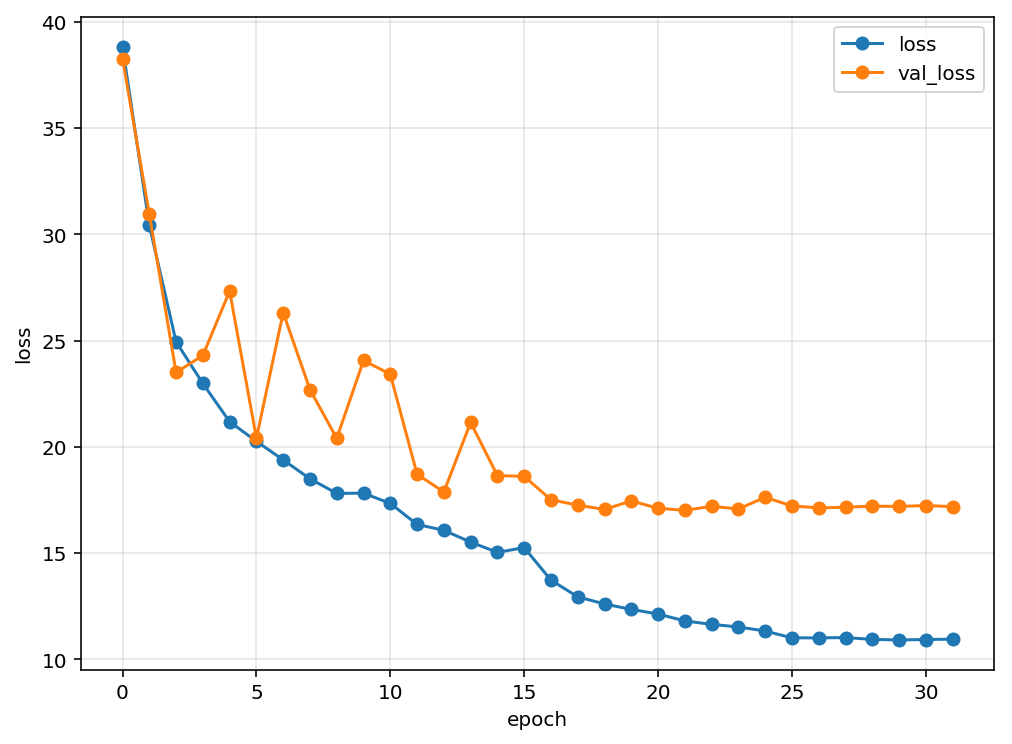

In [46]:
plt.figure(figsize=(18, 6))

#loss
plt.subplot(1, 2, 1)
plt.plot(hist.history["loss"], label="loss", marker="o")
plt.plot(hist.history["val_loss"], label="val_loss", marker="o")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend(loc = "best")
plt.grid(color='gray', alpha=0.2)

plt.show()

In [47]:
score = model.evaluate(X_test, y_test, verbose=1)
print("evaluate loss : {}".format(score))

2370/2370 [==============================] - 5s 2ms/step
evaluate loss : 17.19130611741593


In [48]:
model_dir = 'data/model/'
if os.path.exists(model_dir) == False:
    os.mkdir(model_dir)
    
model.save(model_dir + 'age_model.hdf5')

#model without an optimizer(it can be used only for prediction, not for training and evaluation)
model.save(model_dir + 'age_model_without_opt.hdf5', include_optimizer = False)

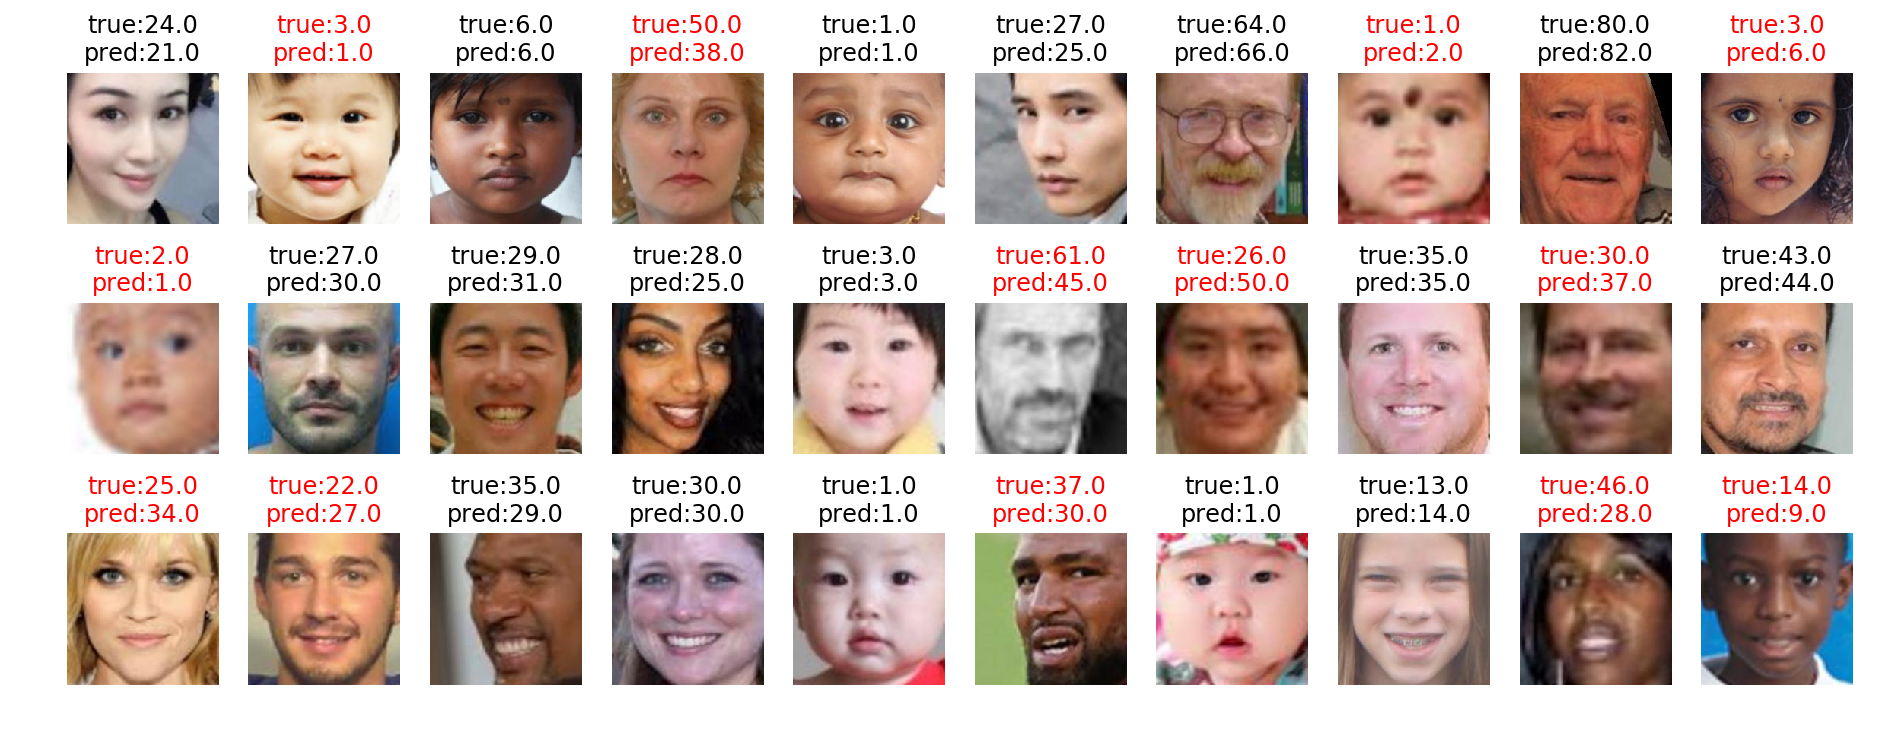

In [75]:
preds = model.predict(X_test[:30])
pred_vals = preds * max_age
true_vals = y_test * max_age

plt.figure(figsize=(16, 6))
for i in range(30):
    plt.subplot(3, 10, i+1)
    plt.axis("off")
    pred = round(pred_vals[i][0])
    true = round(true_vals[i])
    if abs(pred - true) / true < 0.172:
        plt.title('true:' + str(true) + '\n' + 'pred:' + str(pred))
    else:
        plt.title('true:' + str(true) + '\n' + 'pred:' + str(pred), color = "red")
    plt.imshow(X_test[i])
plt.show()